In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import models.linear as linears
import control.agents as agents
import control.environments as env

In [8]:
from utils.notifications import Slack

In [9]:
import copy

# Setup

## Environment


In [29]:
#env_name = 'Taxi-v2'
env_name = 'Breakout-v0'


environment = env.Environment(
    environment=gym.make(env_name), 
    agent=None,
    verbose=True,
    max_steps=200,
    capacity=500,
    #representation_method='one_hot_encoding',
    representation_method='observation',
)

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Model

In [30]:
model_linear = linears.Linear(
    input_dimension=environment.get_input_dimension(), 
    n_actions=environment.n_actions,
)

model_mlp = mlps.MLP(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=250,
    n_hidden_layers=2,
    n_actions=environment.n_actions,
    dropout=.5
)

model_rnn = rnns.RNN(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=50,
    n_actions=environment.n_actions,
    dropout=.3,
    truncate=10
)

## Agent

In [31]:
model = model_mlp

agent = agents.DQNAgent(
    model=model,
    optimiser=torch.optim.Adam(model.parameters(), lr=.001), 
    gamma=.99, 
    temperature=10, 
    algorithm='sarsa', 
    n_actions=environment.n_actions,
    terminal_state=environment.max_obs
)

environment.agent = agent

Load an agent:

In [20]:
#model.load_state_dict(torch.load('../saved/taxi/linear/state_dict_saved.pth'))
#model.load_state_dict(torch.load('../saved/taxi/mlp/state_dict_saved.pth'))
#agent.commit()

# Experiment

## Training

In [32]:
environment.run(
    epochs=10,
    segments=10,
    episodes=100,
    wall_time=2,
    num_evaluation=200,
    batch_size=100,
    #save_directory='../saved/taxi/mlp',
    #log_directory='mlp_obersvations_taxi',
)

TypeError: must be str, not NoneType

100%|###############################################################| 10/10 [01:41<00:00, 10.67s/it]


>> Training return : -552.98


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.44, steps : 200.00


100%|###############################################################| 10/10 [01:08<00:00,  7.13s/it]


>> Training return : -486.82


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.31, steps : 200.00


100%|###############################################################| 10/10 [01:37<00:00, 10.61s/it]


>> Training return : -495.33


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.66, steps : 200.00


100%|###############################################################| 10/10 [01:58<00:00, 12.65s/it]


>> Training return : -489.40


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.94, steps : 200.00


100%|###############################################################| 10/10 [02:34<00:00, 16.82s/it]


>> Training return : -493.23


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.44, steps : 200.00


100%|###############################################################| 10/10 [03:31<00:00, 24.53s/it]


>> Training return : -485.75


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -236.68, steps : 200.00


100%|###############################################################| 10/10 [03:34<00:00, 22.90s/it]


>> Training return : -478.98


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.40, steps : 200.00


100%|###############################################################| 10/10 [03:24<00:00, 18.69s/it]


>> Training return : -460.80


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.40, steps : 200.00


100%|###############################################################| 10/10 [01:47<00:00, 10.14s/it]


>> Training return : -451.64


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -194.68, steps : 193.61


100%|###############################################################| 10/10 [01:46<00:00, 11.13s/it]


>> Training return : -468.44


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.35, steps : 200.00


100%|###############################################################| 10/10 [02:10<00:00, 12.95s/it]


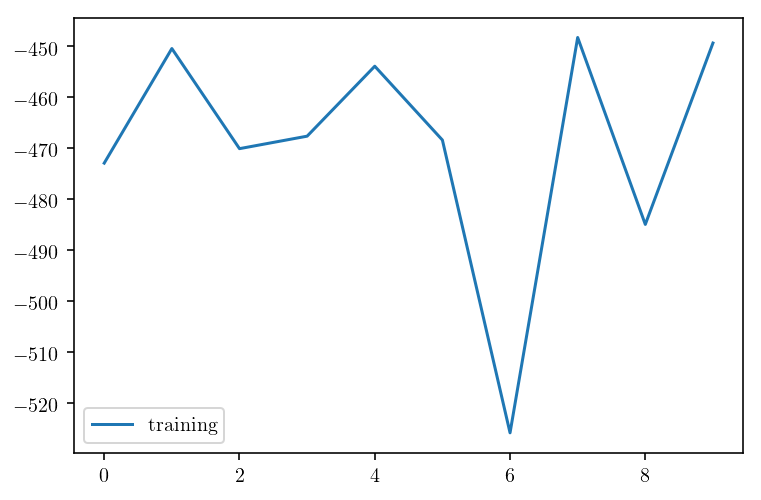

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 100 and 1 in dimension 0 at /Users/soumith/mc3build/conda-bld/pytorch_1549593514549/work/aten/src/TH/generic/THTensorMoreMath.cpp:1307

In [33]:


agent.commit()
returns_train = []
returns_eval = []
q_estimation = []

for _ in range(20):
    
    returns = environment.train(segments=10, episodes=100)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    #plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    agent.temperature *= .95
    
    returns_train.append(np.mean(returns.T[0]))
    returns_eval.append(np.mean(returns.T[1]))
 
    q_estimation.append(environment.agent.q(environment.state_representation(479)))
    print(environment.agent.q(environment.state_representation(1)))
    print(environment.agent.q(environment.state_representation(200)))
    print(environment.agent.q(environment.state_representation(479)))
    
    environment.agent.save('../saved/taxi/rnn')

In [ ]:
plt.figure()
plt.plot(returns_train, label='mean training')
plt.plot(returns_eval, label='mean evaluation')
plt.legend()
plt.show()

q_estimation = np.asarray(q_estimation)
plt.figure()
for i in range(environment.n_actions):
    plt.plot(q_estimation[:, i], label='action ' + str(i))
plt.legend()
plt.show()

## Testing

In [17]:
for _ in range(1):
    environment.exploration_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
269
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
269
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
169
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
149
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
169
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
189
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
89
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
69
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
49
+---------+
|R: | : :G|
| : : : : |
| :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
369
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
369
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
489
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
469
+---------+
|R: | :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
429
+---------+
|R: | : :G|

In [15]:
for _ in range(1):
    environment.evaluation_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

State: 444
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 344
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 244
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 264
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 164
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 184
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 84
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 96
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 76
+---------+
|R: |_: :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:

## Save

In [41]:
environment.agent.save('../saved/mixed_mlp')

In [28]:
environment.agent.terminal_state

0

In [39]:
s = np.zeros(501)
s[479]=1
environment.agent.q(s)

array([-7.6510696, -7.0044036, -8.631231 , -8.776291 , -7.7975073,
       -1.8874221], dtype=float32)